In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import ta
import logging
from typing import Tuple
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
class CryptoDataFetcher:
    def __init__(self):
        self.base_url = "https://api.binance.com/api/v3/klines"
        self.interval = "1m"
        self.limit = 1000

    def _fetch_data(self,coin, start_timestamp: int, end_timestamp: int) -> pd.DataFrame:
        klines = []
        current_start_timestamp = start_timestamp
        current_end_timestamp = start_timestamp + self.limit * 60000

        while current_start_timestamp < end_timestamp:
            if current_end_timestamp > end_timestamp:
                current_end_timestamp = end_timestamp

            url = f"{self.base_url}?symbol={coin}&interval={self.interval}&startTime={current_start_timestamp}&limit={self.limit}"
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()
                for kline in data:
                    klines.append([kline[0], kline[4]]) 
                current_start_timestamp = current_end_timestamp
                current_end_timestamp += self.limit * 60000
            else:
                logging.error("Failed to retrieve data from Binance API")
                break

        df = pd.DataFrame(klines, columns=["Date", "Close"])
        df["Date"] = pd.to_datetime(df["Date"], unit='ms')
        return df

    def get_data(self,coin:str,Pull_latest=False) -> pd.DataFrame:
        try:
            prev_file = pd.read_hdf(f'Data/{coin}.h5', key='my_data')
            prev_file=prev_file[["Date", "Close"]]
            logging.info("Access to old file is granted")
        except FileNotFoundError:
            logging.info("Previous file not found, creating new.")
            prev_file = pd.DataFrame(columns=["Date", "Close"])

        if not prev_file.empty:
            last_date = pd.to_datetime(prev_file["Date"].iloc[-1])
            start_timestamp = int(last_date.timestamp()) * 1000
        else:
            start_timestamp = int((datetime.now() - timedelta(days=1)).timestamp()) * 1000

        end_timestamp = int(datetime.now().timestamp()) * 1000

        if Pull_latest==True:
            new_data = self._fetch_data(coin,start_timestamp, end_timestamp)
            final_data = pd.concat([prev_file, new_data]).drop_duplicates(subset='Date', keep='first')
            final_data.to_hdf(f'Data/{coin}.h5', key='my_data', mode='w')
        else:
            final_data=prev_file

        return final_data
    


In [24]:
class PairTradingStrategy:
    def __init__(self, merged_data: pd.DataFrame, z_score_threshold: float, window1: int, window2: int,
                 look_back: int, rsi_up: float, rsi_down: float):
        # Initialize main parameters
        self.merged_data = merged_data
        self.z_score_threshold = z_score_threshold
        self.window1 = window1
        self.window2 = window2
        self.look_back = look_back
        self.rsi_up = rsi_up
        self.rsi_down = rsi_down
        self.pnl_data = []
        self.btc = merged_data['BTC'].astype(float)
        self.eth = merged_data['ETH'].astype(float)

    def execute_strategy(self) -> float:
        ratios = self.btc / self.eth
        ma1, ma2 = ratios.rolling(window=self.window1).mean(), ratios.rolling(window=self.window2).mean()
        std = ratios.rolling(window=self.window1).std()
        zscore = (ratios - ma2) / std
        ewma_std = ratios.ewm(span=self.window2).std()
        rsi = ta.momentum.RSIIndicator(ratios, window=self.window2).rsi()

        # Initialize trading and PnL variables
        money = 0
        count_btc = count_eth = 0
        position = 0
        transaction_cost = 0.0005  # 0.05%
        MtM = 0
        position_i = 0

        for i in tqdm(range(len(ratios))):
            dynamic_threshold = self.z_score_threshold + ewma_std[i]
            # Short Entry Condition
            if (
                zscore[i] < dynamic_threshold
                and zscore[i - self.look_back:i].max() > dynamic_threshold
                and position == 0
                and rsi[i] > self.rsi_up
            ):
                money, count_btc, count_eth, position, MtM, position_i = self._enter_trade(
                    money, i, ratios, -1, transaction_cost
                )

            # Long Entry Condition
            elif (
                zscore[i] > -dynamic_threshold + 0.2
                and zscore[i - self.look_back:i].min() < -dynamic_threshold
                and position == 0
                and rsi[i] < self.rsi_down
            ):
                money, count_btc, count_eth, position, MtM, position_i = self._enter_trade(
                    money, i, ratios, 1, transaction_cost
                )

            # Exit for Long Position
            elif (
                zscore[i] < dynamic_threshold * 0.5
                and zscore[i - self.look_back:i].max() > dynamic_threshold * 0.5
                and position == 1
            ):
                money, count_btc, count_eth, position, MtM = self._exit_trade(
                    money, i, ratios, count_btc, count_eth, transaction_cost
                )

            # Exit for Short Position
            elif (
                zscore[i] > -dynamic_threshold * 0.5
                and zscore[i - self.look_back:i].min() < -dynamic_threshold * 0.5
                and position == -1
            ):
                money, count_btc, count_eth, position, MtM = self._exit_trade(
                    money, i, ratios, count_btc, count_eth, transaction_cost
                )

            else:
                MtM = self._calculate_mtm(position, i, ratios, position_i)

            # Record PnL data for each step
            self.pnl_data.append([
                ratios.index[i], money, MtM, count_btc, count_eth,
                ma1.iloc[i], ma2.iloc[i], ratios.iloc[i],
                self.btc.iloc[i], self.eth.iloc[i], position,
                zscore.iloc[i], dynamic_threshold, rsi.iloc[i]
            ])

        return money

    def _enter_trade(self, money, i, ratios, position, transaction_cost):
        """Helper function for entering trades"""
        cost = (self.btc[i] + (self.eth[i] * ratios[i])) * transaction_cost
        money += self.btc[i] - self.eth[i] * ratios[i] - cost
        count_btc = -1 if position == -1 else 1
        count_eth = ratios[i] if position == -1 else -ratios[i]
        return money, count_btc, count_eth, position, 0, i

    def _exit_trade(self, money, i, ratios, count_btc, count_eth, transaction_cost):
        """Helper function for exiting trades"""
        cost = (self.btc[i] + (self.eth[i] * ratios[i])) * transaction_cost
        money += self.btc[i] * count_btc + self.eth[i] * count_eth - cost
        return money, 0, 0, 0, 0

    def _calculate_mtm(self, position, i, ratios, position_i):
        """Calculate mark-to-market value"""
        if position == 1:
            return self.btc[i] - self.eth[i] * ratios[position_i]
        elif position == -1:
            return -self.btc[i] + self.eth[i] * ratios[position_i]
        return 0

    def visualize_strategy(self):
        """Visualize the results of the strategy"""
        PnL_df = pd.DataFrame(self.pnl_data, columns=[
            'Date', 'PnL', 'MtM', '#BTC', '#ETH', 'MA1', 'MA2', 'Ratio',
            'Price BTC', 'Price ETH', 'Position', 'z_score', 'Dynamic_Zscore', 'RSI'
        ])
        PnL_df['Date'] = pd.to_datetime(PnL_df['Date'])
        PnL_df.set_index("Date", inplace=True)
        self._plot_strategy(PnL_df)

    def _plot_strategy(self, df):
        """Helper to organize and create the strategy visualization"""
        fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

        # Plot BTC and ETH Pair Ratio
        axes[0].plot(df['Ratio'], label='Ratio')
        axes[0].axhline(df['Ratio'].mean(), color='black')
        axes[0].plot(df['MA1'], label="EMA1")
        axes[0].plot(df['MA2'], label="EMA2")
        axes[0].legend(loc='upper left')
        axes[0].set_title('BTC and ETH Pair Ratio')

        # Plot Z-Score with Dynamic Thresholds
        axes[1].plot(df['z_score'], label='Z-Score', color='orange')
        axes[1].plot(df['Dynamic_Zscore'], color='r', linestyle='--', label='Upper Threshold')
        axes[1].plot(-df['Dynamic_Zscore'], linestyle='--', label='Lower Threshold')
        axes[1].plot(df['Dynamic_Zscore'] * 0.5, color='g', linestyle='--', label='Mid Threshold')
        axes[1].plot(-df['Dynamic_Zscore'] * 0.5, color='g', linestyle='--', label='Mid Threshold')
        axes[1].plot(df['Position'], color='grey', linestyle='--', label='Position')
        axes[1].legend(loc='upper left')
        axes[1].set_title('Z-Score')

        # Plot PnL and MtM
        axes[2].plot(df['PnL'], label='PnL', color='purple')
        axes[2].plot(df['MtM'], label='MtM', color='red')
        axes[2].legend(loc='upper left')
        axes[2].set_title('PnL of strategy')

        # Plot RSI
        axes[3].plot(df['RSI'], label='RSI', color='orange')
        axes[3].axhline(y=50, color='r', linestyle='--')
        axes[3].legend(loc='upper left')
        axes[3].set_title('RSI')
        
        plt.show()
        df.to_excel("log.xlsx")


2024-10-26 14:45:34,126 - INFO - Access to old file is granted
2024-10-26 14:45:34,426 - INFO - Access to old file is granted
100%|██████████| 100000/100000 [00:26<00:00, 3705.12it/s]


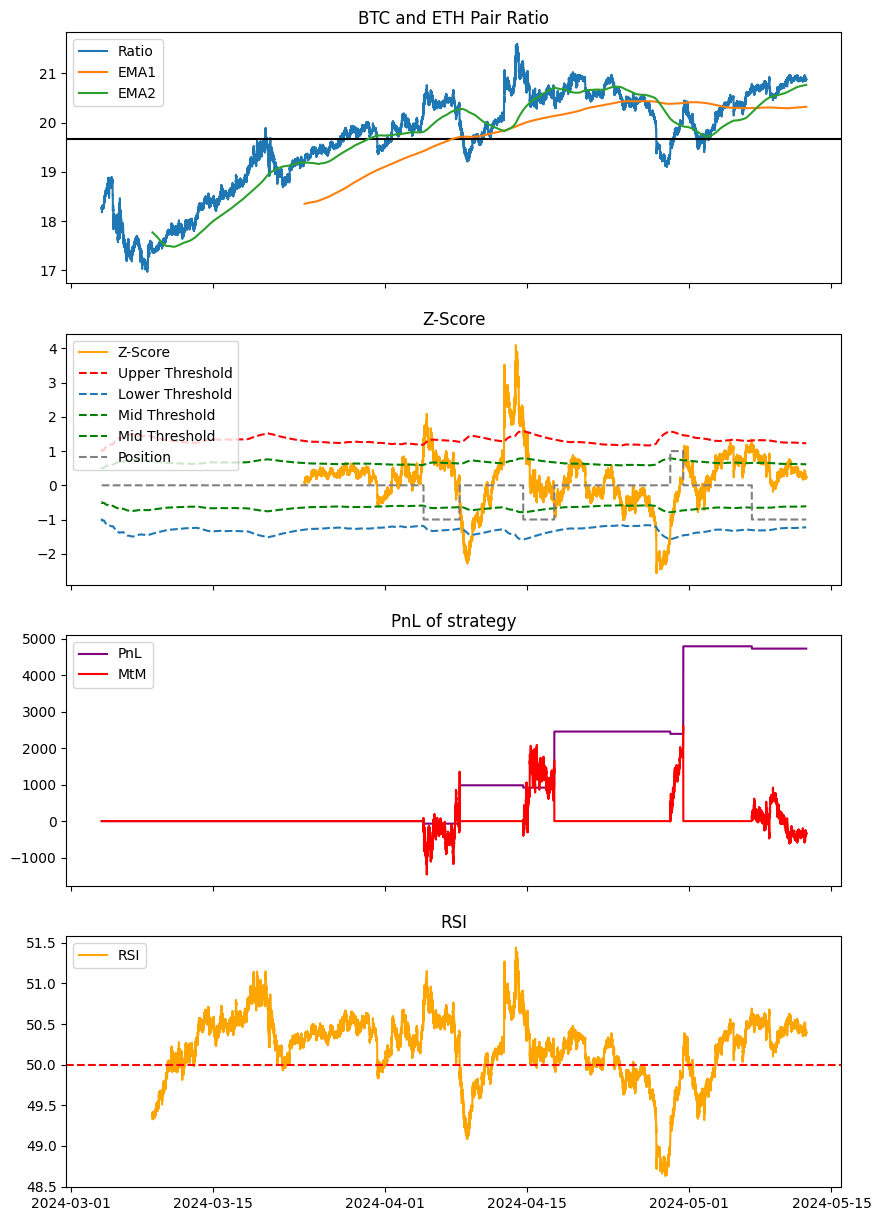

In [25]:
if __name__ == "__main__":
    data_fetcher=CryptoDataFetcher()
    btc_data = data_fetcher.get_data('BTCUSDT',Pull_latest=False)
    eth_data = data_fetcher.get_data('ETHUSDT',Pull_latest=False)
    btc_data['Date'] = pd.to_datetime(btc_data['Date'])
    eth_data['Date'] = pd.to_datetime(eth_data['Date'])
    btc_data = btc_data.rename(columns={'Open time': 'Date', 'Close': 'BTC'})
    eth_data = eth_data.rename(columns={'Open time': 'Date', 'Close': 'ETH'})
    merged_data=pd.merge(btc_data,eth_data,on='Date',how='left').dropna()
    merged_data=merged_data.set_index('Date')
    strategy = PairTradingStrategy(merged_data[-100000:], 1, 28800, 7200,60*12,50.5,49.5)
    strategy.execute_strategy()
    strategy.visualize_strategy()